In [8]:
import pandas as pd
import numpy as np
import src.get_data as get_data

import keras
from scipy import stats
from keras.layers.core import Dense, Activation, Dropout
from keras.layers.recurrent import LSTM
from keras.models import Sequential, load_model, save_model

import datetime 
import seaborn as sns
from pylab import rcParams
from sklearn.preprocessing import MinMaxScaler
from sklearn import metrics
import time
import matplotlib.pyplot as plt

import plotly as py
import plotly.graph_objs as go
from plotly.offline import init_notebook_mode, iplot

import sqlalchemy

init_notebook_mode(connected=True)

%matplotlib inline

sns.set(style='whitegrid', palette='muted', font_scale=1.5)

rcParams['figure.figsize'] = 14, 8

RANDOM_SEED = 42

WINDOW = 22

In [9]:

def time_series_split(X, test_size=.1, number=False, output_numpy=True):
    """
    Split data to train and test sets

    """
    is_pandas = isinstance(X, pd.DataFrame) or isinstance(X, pd.Series)
    
    if test_size <= 1 and not number:
        ntrn = int(len(X) * (1 - test_size))
    elif test_size > 1 and number:
        ntrn = int(len(X) - test_size)
    else:
        raise ValueError("test_size: (frac or Int) and number:(True or False) should be set correctly")

    if is_pandas:
        X_train = X.iloc[0:ntrn]
        X_test = X.iloc[ntrn:]
    else:
        X_train = X[0:ntrn]
        X_test = X[ntrn:]

    if output_numpy and is_pandas:
        return X_train.as_matrix(), X_test.as_matrix()
    else:
        return X_train, X_test

In [42]:
X = df[['low', 'high', 'open','volume']]
# = pd.ewma(X, halflife=10)
y = df[['close']]
# = pd.ewma(y, halflife=10)

X_train, X_test = time_series_split(X)
y_train, y_test = time_series_split(y)

/root/anaconda/lib/python3.6/site-packages/sklearn/linear_model/coordinate_descent.py:484: ConvergenceWarning:

Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.



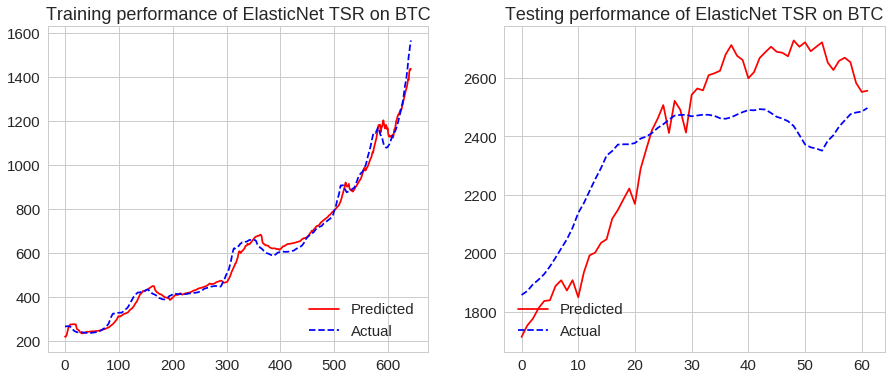

In [38]:
from sklearn.linear_model import ElasticNet

n_prev=2; n_ahead=10
lasso = ElasticNet(alpha=1, l1_ratio=1)
lasso_tsr = TimeSeriesRegressor(lasso, n_prev=n_prev,n_ahead=n_ahead,alpha=1) 

# Note that ElasticNet parameters can be input in the ElasticNet() or the TimeSeriesRegressor()
# This allows grid search and other meta estimation techniques to access the parameters of the base_estimator
lasso_tsr.fit(X_train, y_train)
pred_train_2 = lasso_tsr.predict(X_train) #outputs a numpy array of length: len(X_train)-n_prev
pred_test_2 = lasso_tsr.predict(X_test)

train_test_plot(pred_train_2,y_train,pred_test_2,y_test,n_prev,'ElasticNet TSR on BTC',n_ahead)

In [46]:
pred_test_2.shape

(62,)

In [53]:
y.shape[0] - 62

665

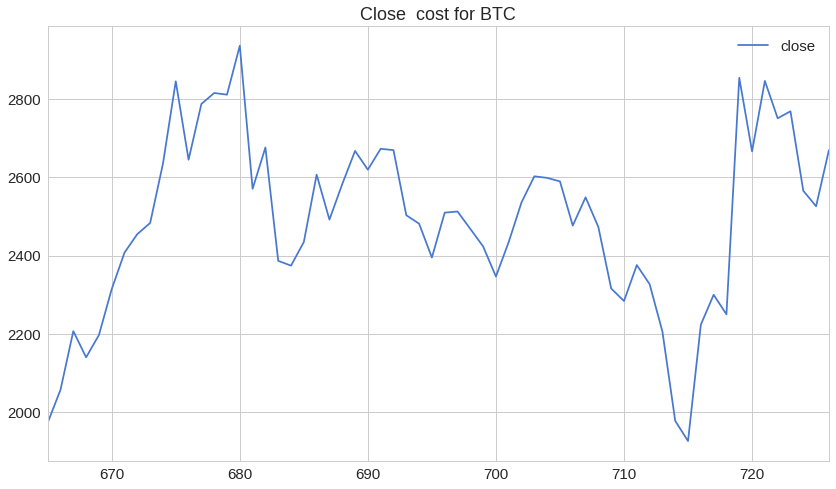

In [56]:
y[665:].plot()
plt.title("Close  cost for BTC")
plt.show()

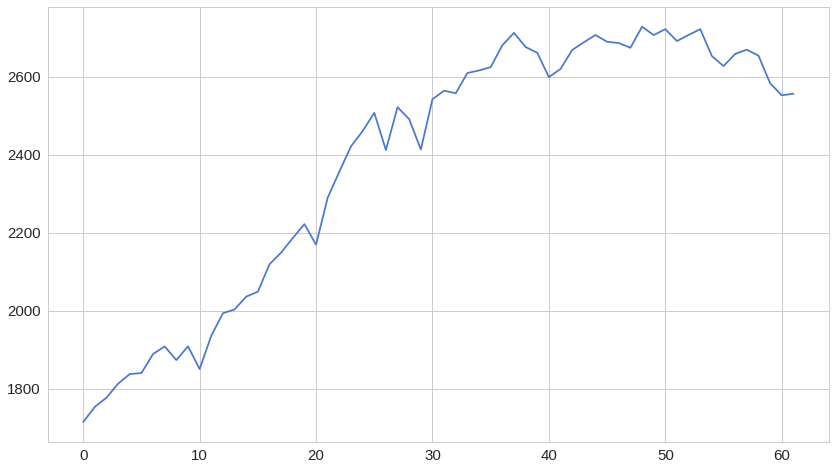

In [57]:
plt.plot(pred_test_2)

# TIME SERIES REGRESSOR

In [25]:
from sklearn.base import BaseEstimator, RegressorMixin, clone


class TimeSeriesEstimator(BaseEstimator):
    """
    Base Class for Time Series Estimators
    """

    def __init__(self, base_estimator, n_prev=3, n_ahead=1, parallel_models=False, **base_params):
        self.base_estimator = base_estimator.set_params(**base_params)
        self.parallel_models = parallel_models
        self.n_prev = n_prev
        self.n_ahead = n_ahead
        self._fit_estimators = None
        self._is_autocor = None

    def set_params(self, **params):
        for param, value in params.iteritems():
            if param in self.get_params():
                super(TimeSeriesEstimator, self).set_params(**{param: value})
            else:
                self.base_estimator.set_params(**{param: value})
        return self

    def __repr__(self):
        return "TimeSeriesEstimator: " + repr(self.base_estimator)

    def _window_dataset(self, n_prev, dataX, dataY=None, n_ahead=1):
        """
        converts a dataset into an autocorrelation dataset with number of previous time steps = n_prev
        returns a an X dataset of shape (samples, timesteps, features) and a Y dataset of shape (samples,features)
        """
        is_pandas = isinstance(dataX, pd.DataFrame)

        if dataY is not None:
            # assert (type(dataX) is type(dataY)) TODO find way to still perform this check
            assert (len(dataX) == len(dataY))

        dlistX, dlistY = [], []
        for i in range(len(dataX) - n_prev + 1 - n_ahead):
            if is_pandas:
                dlistX.append(dataX.iloc[i:i + n_prev].as_matrix())
                if dataY is not None:
                    dlistY.append(dataY.iloc[i + n_prev - 1 + n_ahead].as_matrix())
                else:
                    dlistY.append(dataX.iloc[i + n_prev - 1 + n_ahead].as_matrix())
            else:
                dlistX.append(dataX[i:i + n_prev])
                if dataY is not None:
                    dlistY.append(dataY[i + n_prev - 1 + n_ahead])
                else:
                    dlistY.append(dataX[i + n_prev - 1 + n_ahead])

        darrX = np.array(dlistX)
        darrY = np.array(dlistY)
        return darrX, darrY

    def _unravel_window_data(self, data):
        """
        converts a dataset of shape (samples, timesteps, features) to a dataset
        of shape (samples,timesteps*features)
        """
        dlist = []
        one_dim = True if len(data.shape) == 2 else False
        for i in range(data.shape[0]):
            if one_dim:
                dlist.append(data[i, :].ravel())
            else:
                dlist.append(data[i, :, :].ravel())
        return np.array(dlist)

    def offset_data(self, Y):
        '''
        Automatically calculates the correct offset of data in order to match
        the regressed data resulting from the predict function
        :param Y:
        :return:
        '''
        if len(Y.shape) > 1:
            return Y[self.n_prev - 1 + self.n_ahead:, :]
        else:
            return Y[self.n_prev - 1 + self.n_ahead:]

    def _preprocess(self, X, Y):
        '''
        Converts the data into a format so that it can be fed into any sklearn regressor
        :param X:
        :param Y:
        :return:
        '''
        X_wind, Y_data = self._window_dataset(self.n_prev, X, Y, self.n_ahead)
        X_data = self._unravel_window_data(X_wind)
        return X_data, Y_data

    def fit(self, X, Y=None):
        ''' X and Y are datasets in chronological order, or X is a time series '''

        self._is_autocor = True if Y is None else False

        X_data, Y_data = self._preprocess(X, Y)

        if self.parallel_models and len(Y_data.shape) > 1 and Y_data.shape[1] > 1:
            self._fit_estimators = [clone(self.base_estimator) for i in range(Y_data.shape[1])]
            for i, estimator in enumerate(self._fit_estimators):
                estimator.fit(X_data, Y_data[:, i])
        else:
            self.base_estimator.fit(X_data, Y_data)

        return self


class TimeSeriesRegressor(TimeSeriesEstimator, RegressorMixin):
    """
    A wrapper object for any scikit learn regressor. This object is designed to turn any regressor
    into a time series regressor.
    """

    def score(self, X, Y, **kwargs):
        return self.base_estimator.score(*self._preprocess(X, Y), **kwargs)

    def predict(self, X, preprocessed=False):
        if not preprocessed:
            X_new = self._preprocess(X, Y=None)[0]
        else:
            X_new = X

        if self._fit_estimators is not None:
            results = []
            for estimator in self._fit_estimators:
                results.append(estimator.predict(X_new))
            return np.transpose(np.array(results))
        else:
            return self.base_estimator.predict(X_new)

    def forecast(self, X, n_steps, noise=0, n_paths=1, combine=None):
        '''
        Forecast using a training dataset, n_steps into the future
        This is acchomplished by feeding the output data back into the regressor
        aka stepping time forward by one step
        :param X:
        :param n_steps:
        :return:
        '''
        if not (
            self._is_autocor and self.n_ahead == 1):  # TODO generalize and add exponential weighting on older predictions
            raise ValueError("Need to be an auto-correlation predictor with n_ahead=1")

        is_pandas = isinstance(X, pd.DataFrame) or isinstance(X, pd.Series)
        if is_pandas:
            X = X.as_matrix()

        outs = []
        for i in range(n_paths):
            out = np.empty((n_steps, X.shape[1]))
            previous = X[-self.n_prev:]
            for i in range(n_steps):
                next_step = self.predict(np.array([previous.ravel()]), preprocessed=True)
                out[i, :] = next_step + next_step * np.random.randn(*next_step.shape) * noise
                previous = np.vstack((previous[1:], next_step))
            outs.append(out)

        if combine == 'mean' and n_paths > 1:
            return np.array(outs).mean(axis=0)
        elif n_paths > 1:
            return np.array(outs)
        else:
            return out

In [26]:
from sklearn.linear_model import LinearRegression
n_prev=2
linear_model = LinearRegression()

linear_tsr = TimeSeriesRegressor(linear_model, n_prev=n_prev)

linear_tsr.fit(X_train, y_train)
pred_train = linear_tsr.predict(X_train) 
pred_test = linear_tsr.predict(X_test)

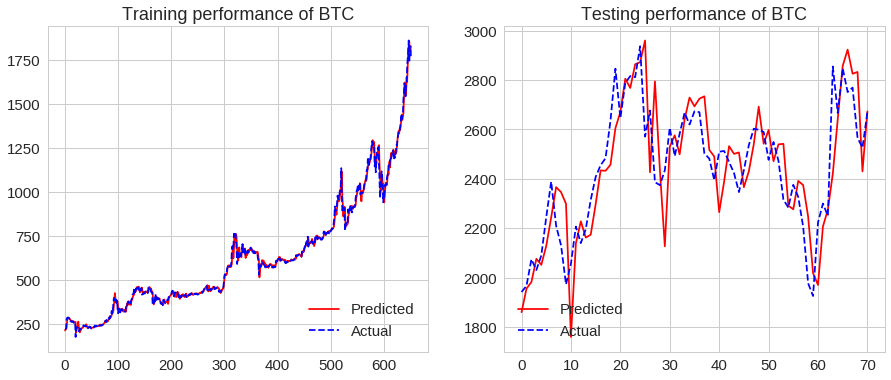

In [27]:
def train_test_plot(pred_train,y_train,pred_test,y_test,n_prev, title, n_ahead=1):
    plt.subplot(1,2,1)
    plt.plot(pred_train[:], 'r', label="Predicted")
    plt.plot(y_train[n_prev-1+n_ahead:], 'b--', label="Actual") 
    #nprev: because the first predicted point needed n_prev steps of data
    plt.title("Training performance of "+title)
    plt.legend(loc='lower right')

    plt.subplot(1,2,2)
    plt.plot(pred_test[:], 'r', label="Predicted")
    plt.plot(y_test[n_prev-1+n_ahead:], 'b--', label="Actual") 
    #nprev: because the first predicted point needed n_prev steps of data
    plt.title("Testing performance of " +title)
    plt.legend(loc='lower left')

    plt.gcf().set_size_inches(15,6)
    plt.show()

train_test_plot(pred_train,y_train,pred_test,y_test,n_prev,'BTC')

Предсказание на несколько дней вперед с n_ahead

/root/anaconda/lib/python3.6/site-packages/sklearn/linear_model/coordinate_descent.py:484: ConvergenceWarning:

Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.



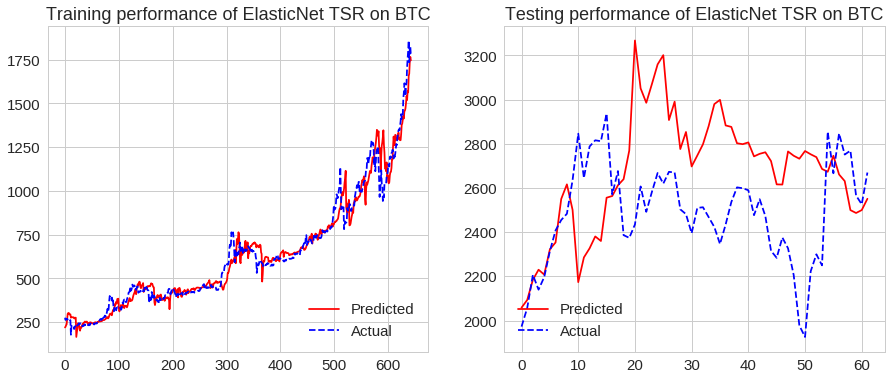

In [28]:
from sklearn.linear_model import ElasticNet

n_prev=2; n_ahead=10
lasso = ElasticNet(alpha=1, l1_ratio=1)
lasso_tsr = TimeSeriesRegressor(lasso, n_prev=n_prev,n_ahead=n_ahead,alpha=1) 

# Note that ElasticNet parameters can be input in the ElasticNet() or the TimeSeriesRegressor()
# This allows grid search and other meta estimation techniques to access the parameters of the base_estimator
lasso_tsr.fit(X_train, y_train)
pred_train_2 = lasso_tsr.predict(X_train) #outputs a numpy array of length: len(X_train)-n_prev
pred_test_2 = lasso_tsr.predict(X_test)

train_test_plot(pred_train_2,y_train,pred_test_2,y_test,n_prev,'ElasticNet TSR on BTC',n_ahead)

In [20]:
df.tail()

,date,time,open,close,low,high,volume,name
722,2017-07-23,07:00:00,2847.000000,2751.430834,2655.000000,2880.151217,4.548646e+07,USDT_BTC
723,2017-07-24,07:00:00,2751.430834,2769.363636,2705.010000,2815.517448,3.298703e+07,USDT_BTC
724,2017-07-25,07:00:00,2769.363636,2565.999999,2417.330010,2800.000000,1.026457e+08,USDT_BTC
725,2017-07-26,07:00:00,2565.999999,2526.350647,2400.000000,2619.964935,5.210492e+07,USDT_BTC
726,2017-07-27,07:00:00,2526.350647,2669.999998,2506.440227,2695.651484,3.632087e+07,USDT_BTC


IndexError: index 3 is out of bounds for axis 1 with size 1

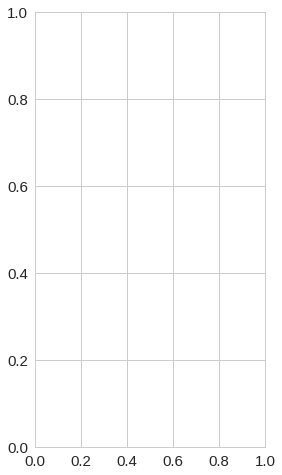

In [66]:
X = x
names = list(X.columns.values)
X_train, X_test = time_series_split(X)

n_prev = 3
tsr = TimeSeriesRegressor(LinearRegression(), n_prev=n_prev)
tsr.fit(X_train)
fc = tsr.forecast(X_train, len(X_test))
def changes(X):
    return np.array([X[-1, i] - X[0, i] for i in range(X.shape[1])])

plt.subplot(1,3,1)
stock=3
plt.plot(fc[:,stock],'r',label='Forecast of '+names[stock])
plt.plot(X_test[:,stock],'b',label='Actual price of '+names[stock])
plt.ylabel('Price')
plt.xlabel('Day')
plt.legend(loc='upper left')

plt.subplot(1,3,2)
stock=11
plt.plot(fc[:,stock],'r',label='Forecast of '+names[stock])
plt.plot(X_test[:,stock],'b',label='Actual price of '+names[stock])
plt.ylabel('Price')
plt.xlabel('Day')
plt.legend(loc='upper left')

plt.subplot(1,3,3)
X_test_change = changes(np.log(X_test))
fc_change = changes(np.log(fc))
x = np.linspace(min(X_test_change), max(X_test_change))
plt.plot(x,x,'b',label='y = x')
plt.plot(X_test_change, fc_change, 'r.',label='data', alpha=.3)
plt.title('Predicted vs. Actual Changes in Price')
plt.xlabel('Actual price change in log(dollars)')
plt.ylabel('Forecasted price change in log(dollars)')
plt.legend(loc='upper left')

plt.gcf().set_size_inches(16,5)
plt.show()

In [60]:
y_test[-1]

array([ 2669.999998])